### Importation of the different libraries

In [16]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import Birch, DBSCAN, OPTICS, AgglomerativeClustering, BisectingKMeans, KMeans, MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import HDBSCAN
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split


import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

#import tensorflow as tf
#import tensorflow.keras as tfk
#import tensorflow.keras.layers as tfkl
#from keras import regularizers
#from keras.models import load_model
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.initializers import glorot_uniform

### Load the "cleaned" matrix created in the feature_generation file

In [4]:
cleaned_df = pd.read_csv('cleaned.csv')
cleaned = cleaned_df.to_numpy()

### AE train

In [8]:
tf.random.set_seed(54)
x_train, x_test = train_test_split(cleaned, test_size=0.3, random_state=1)


x_train = np.array(x_train)
x_test = np.array(x_test)

# Set random seed
tf.random.set_seed(54)

# Encoder
inputs = tfkl.Input(shape = (251))
x = inputs
#x = tfkl.Dense(512,'relu')(x)
#x = tfkl.Dense(64,'relu')(x)
#x = tfkl.Dense(32,'relu')(x)
x = tfkl.Dense(16,'relu')(x)
encoder = tfk.Model(inputs = inputs, outputs = x)

# Decoder
inputs = tfkl.Input(shape = (16))
x = inputs
#x = tfkl.Dense(32,'relu')(x)
#x = tfkl.Dense(128,'relu')(x)
#x = tfkl.Dense(512,'relu')(x)
x = tfkl.Dense(251*1,'relu')(x)
decoder = tfk.Model(inputs = inputs, outputs = x)

# Autoencoder
inputs = tfkl.Input(shape = (251))
x = encoder(inputs)
x = decoder(x)
model = tfk.Model(inputs = inputs, outputs = x)

# Train the Autoencoder
model.compile(loss = 'mse',optimizer = 'adam')
model.fit(x_train, x_train,epochs = 10,batch_size = 32)



latent = encoder.predict(cleaned)

encoder.save('pca50_encoder32_10epoch.h5')

Epoch 1/10
3/3 [==============================] - 1s 6ms/step - loss: 0.8946
Epoch 2/10
3/3 [==============================] - 0s 6ms/step - loss: 0.8791
Epoch 3/10
3/3 [==============================] - 0s 4ms/step - loss: 0.8673
Epoch 4/10
3/3 [==============================] - 0s 5ms/step - loss: 0.8581
Epoch 5/10
3/3 [==============================] - 0s 4ms/step - loss: 0.8512
Epoch 6/10
3/3 [==============================] - 0s 8ms/step - loss: 0.8446
Epoch 7/10
3/3 [==============================] - 0s 11ms/step - loss: 0.8389
Epoch 8/10
3/3 [==============================] - 0s 8ms/step - loss: 0.8342
Epoch 9/10
3/3 [==============================] - 0s 6ms/step - loss: 0.8292
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


/Users/mjolif/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### VAE train

This step takes 9 minutes with Google collab T4 GPU

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
data_set = np.float32(cleaned)
trainloader = DataLoader(dataset=data_set, batch_size=1024)


class Autoencoder(nn.Module):
    def __init__(self, D_in, H=50, H2=12, latent_dim=32):

        # Encoder
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        #         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        #         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        #         # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu


    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar, z


###################################################################
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD


######################################################################
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)


########################################################################
D_in = 251
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = customLoss()

#########################################################################
# Training
epochs = 1000
log_interval = 50
val_losses = []
train_losses = []


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #        if batch_idx % log_interval == 0:
        #            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #                epoch, batch_idx * len(data), len(trainloader.dataset),
        #                       100. * batch_idx / len(trainloader),
        #                       loss.item() / len(data)))
    if epoch % 200 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))


for epoch in range(1, epochs + 1):
    train(epoch)

###########################################################################
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z = model(data)

        mu_tensor = mu
        mu_output.append(mu_tensor)
        mu_result = torch.cat(mu_output, dim=0)

        logvar_tensor = logvar
        logvar_output.append(logvar_tensor)
        logvar_result = torch.cat(logvar_output, dim=0)

##################################################################################

pred = mu_result.cpu().detach().numpy()
np.save('pred_vae32_1500_epochs.npy', pred)

####################################################################################

====> Epoch: 200 Average loss: 170.7861
====> Epoch: 400 Average loss: 116.1816
====> Epoch: 600 Average loss: 89.6426
====> Epoch: 800 Average loss: 75.0385
====> Epoch: 1000 Average loss: 62.5702


In [7]:
VAE_32 = np.load('pred_vae32_1500_epochs.npy')

### Choose the best number of clusters (K)

This step take a lot of time because of the computation time of the silhouette coefficient (45min with google collab CPU)

In [15]:
loaded_array = VAE_32
km_scores = []
vae32 = []
db_score = []
for i in range(5, 200, 5):
    km = KMeans(n_clusters=i, random_state=25, n_init=10).fit(loaded_array)
    km_preds = km.predict(loaded_array)
    
    #Calculating the silhouette coefficiant takes time
    silhouette = silhouette_score(loaded_array, km_preds, random_state=25)
    vae32.append(silhouette)

In [16]:
plt.figure(figsize=(250, 80))
plt.title("", fontsize=96)
plt.scatter(x=[i for i in range(5, 200, 5)], y=vae32, s=6000, edgecolor='k', color='blue')
plt.grid(True, linewidth=10)
plt.xlabel("\nNumber of clusters for the K-means Model", fontsize=180)
plt.ylabel("Silhouette score\n", fontsize=180)
plt.xticks([i for i in range(5, 200, 5)], fontsize=150)
plt.yticks(fontsize=150)
plt.show()

### BIRCH train & Evaluation

In [7]:
loaded_array = cleaned

brc = Birch(threshold=0.5, branching_factor=50, n_clusters=30, compute_labels=True, copy=True)
brc.fit(loaded_array)
birch_labels = brc.labels_

In [8]:
ch = metrics.calinski_harabasz_score(loaded_array, birch_labels)
print('ch Score: %.3f' % ch)

ss = silhouette_score(loaded_array, birch_labels, metric='euclidean')
print('Silhouetter Score: %.3f' % ss)

DB = davies_bouldin_score(loaded_array, birch_labels)
print('DB Score: %.3f' % DB)

ch Score: 840.342
Silhouetter Score: 0.042
DB Score: 2.181


In [9]:
VAE_16 = np.load('pred_vae16_1000_epochs.npy')
VAE_32 = np.load('pred_vae32_1000_epochs.npy')
VAE_64 = np.load('pred_vae64_1000_epochs.npy')

### Kmeans Evaluation

In [23]:
loaded_array = VAE_32

##K-Means & Internal clustering evaluations
kmeans = KMeans(15,random_state=21, n_init=20)
kmeans.fit(loaded_array)
kmeanslabels = kmeans.labels_

In [24]:
ch = metrics.calinski_harabasz_score(loaded_array, kmeanslabels)
print('ch Score: %.3f' % ch)

ss = silhouette_score(loaded_array, kmeanslabels, metric='euclidean')
print('Silhouetter Score: %.3f' % ss)

DB = davies_bouldin_score(loaded_array, kmeanslabels)
print('DB Score: %.3f' % DB)

ch Score: 7575.908
Silhouetter Score: 0.223
DB Score: 1.199


### Bisecting Kmeans train & evaluation

In [8]:
loaded_array = VAE_32

for i in range(5,100,5):
    print(i)
    bisectingkmeans = BisectingKMeans(i,random_state=21, n_init=10)
    bisectingkmeans.fit(loaded_array)
    labels_bisectingkmeans = bisectingkmeans.labels_

    ch = metrics.calinski_harabasz_score(loaded_array, labels_bisectingkmeans)
    print('ch Score: %.3f' % ch)

    ss = silhouette_score(loaded_array, labels_bisectingkmeans, metric='euclidean')
    print('Silhouetter Score: %.3f' % ss)

    DB = davies_bouldin_score(loaded_array, labels_bisectingkmeans)
    print('DB Score: %.3f' % DB)

5
ch Score: 8112.950
Silhouetter Score: 0.161
DB Score: 1.621
10
ch Score: 6677.805
Silhouetter Score: 0.140
DB Score: 1.561
15
ch Score: 6371.956
Silhouetter Score: 0.163
DB Score: 1.469
20
ch Score: 5715.197
Silhouetter Score: 0.156
DB Score: 1.424
25
ch Score: 5190.460
Silhouetter Score: 0.144
DB Score: 1.437
30
ch Score: 4971.206
Silhouetter Score: 0.153
DB Score: 1.390
35
ch Score: 4753.198
Silhouetter Score: 0.152
DB Score: 1.455
40
ch Score: 4671.040
Silhouetter Score: 0.157
DB Score: 1.410
45
ch Score: 4443.872
Silhouetter Score: 0.154
DB Score: 1.419
50
ch Score: 4242.036
Silhouetter Score: 0.153
DB Score: 1.431
55
ch Score: 4091.036
Silhouetter Score: 0.151
DB Score: 1.420
60
ch Score: 3952.478
Silhouetter Score: 0.150
DB Score: 1.408
65
ch Score: 3821.698
Silhouetter Score: 0.146
DB Score: 1.408
70
ch Score: 3695.272
Silhouetter Score: 0.146
DB Score: 1.410
75
ch Score: 3600.678
Silhouetter Score: 0.146
DB Score: 1.413
80
ch Score: 3516.554
Silhouetter Score: 0.144
DB Score:

### DBSCAN train & Evaluation

In [9]:
loaded_array = VAE_32

EPS = 2

Dbscan = DBSCAN(eps = EPS)
Dbscan.fit(loaded_array)
labels_DBSCAN = Dbscan.labels_

In [10]:
# taking an input list
input_list = labels_DBSCAN

l1 = []

# taking a counter
count = 0

for item in input_list:
    if item not in l1:
        count += 1
        l1.append(item)

# printing the output
print("No of unique items are:", count)
print("values:", l1)

No of unique items are: 3
values: [0, -1, 1]


In [11]:
ch = metrics.calinski_harabasz_score(loaded_array, labels_DBSCAN)
print('ch Score: %.3f' % ch)

ss = silhouette_score(loaded_array, labels_DBSCAN, metric='euclidean')
print('Silhouetter Score: %.3f' % ss)

DB = davies_bouldin_score(loaded_array, labels_DBSCAN)
print('DB Score: %.3f' % DB)

ch Score: 132.724
Silhouetter Score: 0.575
DB Score: 0.968


### HDBSCAN train & evaluation

In [20]:
loaded_array = VAE_32

HDbscan = HDBSCAN(min_cluster_size=100)
HDbscan.fit(loaded_array)
labels_HDBSCAN = HDbscan.labels_

In [21]:
# taking an input list
input_list = labels_HDBSCAN

l1 = []

# taking a counter
count = 0

for item in input_list:
    if item not in l1:
        count += 1
        l1.append(item)

# printing the output
print("No of unique items are:", count)
print("values:", l1)

No of unique items are: 12
values: [9, -1, 10, 8, 1, 5, 3, 2, 4, 7, 6, 0]


In [22]:
ch = metrics.calinski_harabasz_score(loaded_array, labels_HDBSCAN)
print('ch Score: %.3f' % ch)

ss = silhouette_score(loaded_array, labels_HDBSCAN, metric='euclidean')
print('Silhouetter Score: %.3f' % ss)

DB = davies_bouldin_score(loaded_array, labels_HDBSCAN)
print('DB Score: %.3f' % DB)

ch Score: 652.650
Silhouetter Score: -0.123
DB Score: 2.234


### OPTICS train & Evaluation

In [33]:
loaded_array = VAE_32

Optics = OPTICS(min_samples = 50)
Optics.fit(loaded_array)
labels_OPTICS = Optics.labels_

In [34]:
# taking an input list
input_list = labels_OPTICS

l1 = []

# taking a counter
count = 0

for item in input_list:
    if item not in l1:
        count += 1
        l1.append(item)
R
# printing the output
print("No of unique items are:", count)
print("values:", l1)

No of unique items are: 6
values: [-1, 4, 2, 3, 0, 1]


In [35]:
ch = metrics.calinski_harabasz_score(loaded_array, labels_OPTICS)
print('ch Score: %.3f' % ch)

ss = silhouette_score(loaded_array, labels_OPTICS, metric='euclidean')
print('Silhouetter Score: %.3f' % ss)

DB = davies_bouldin_score(loaded_array, labels_OPTICS)
print('DB Score: %.3f' % DB)

ch Score: 121.111
Silhouetter Score: -0.150
DB Score: 0.936


### Meanshift train & evaluation

In [16]:
loaded_array = VAE_32


meanshift = MeanShift(bandwidth = 3)
meanshift.fit(loaded_array)
labels_meanshift = meanshift.labels_

In [17]:
# taking an input list
input_list = labels_meanshift

l1 = []

# taking a counter
count = 0

for item in input_list:
    if item not in l1:
        count += 1
        l1.append(item)

# printing the output
print("No of unique items are:", count)
print("values:", l1)

No of unique items are: 8
values: [0, 7, 1, 3, 2, 5, 6, 4]


In [18]:
ch = metrics.calinski_harabasz_score(loaded_array, labels_meanshift)
print('ch Score: %.3f' % ch)

ss = silhouette_score(loaded_array, labels_meanshift, metric='euclidean')
print('Silhouetter Score: %.3f' % ss)

DB = davies_bouldin_score(loaded_array, labels_meanshift)
print('DB Score: %.3f' % DB)

ch Score: 213.409
Silhouetter Score: 0.484
DB Score: 1.329


In [15]:
meanshift.get_params()

{'bandwidth': None,
 'bin_seeding': False,
 'cluster_all': True,
 'max_iter': 300,
 'min_bin_freq': 1,
 'n_jobs': None,
 'seeds': None}

### Visualize Results

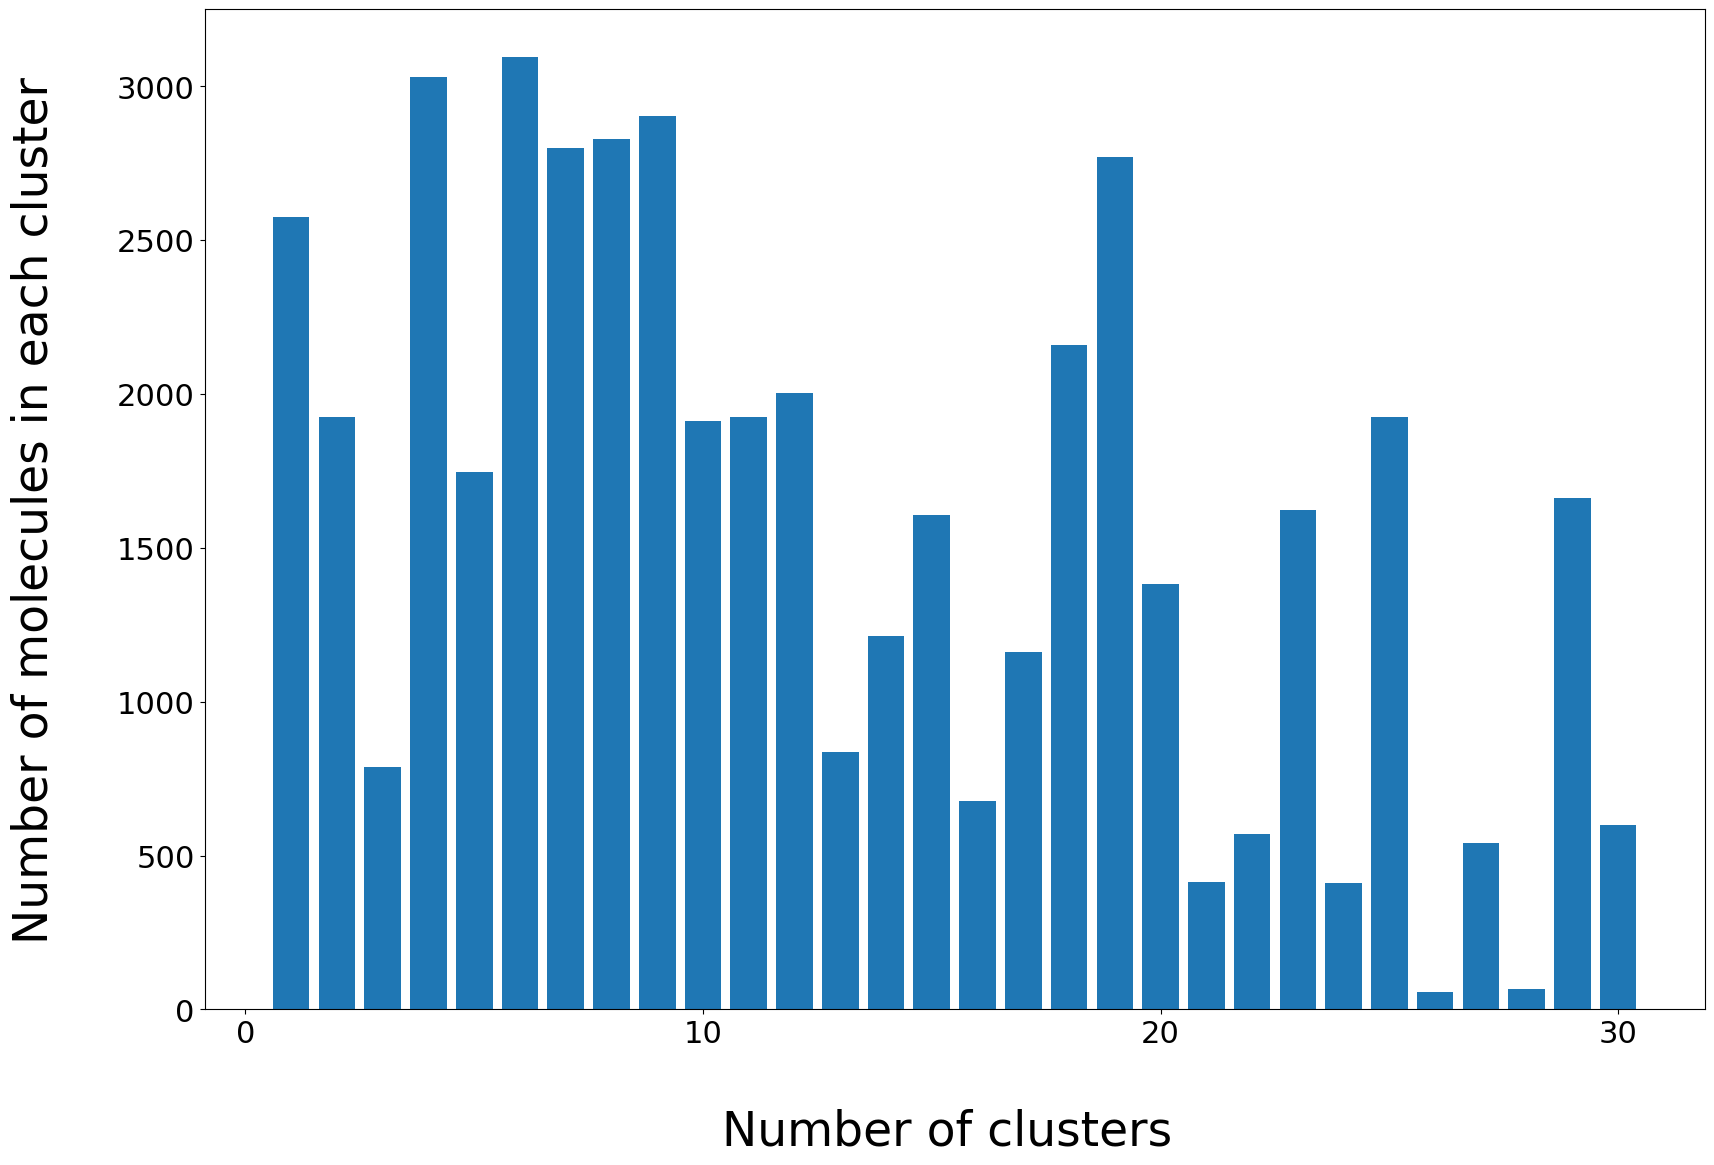

In [11]:
## Visualize Results


# 1. Density Plot
pred = pd.DataFrame(data=VAE_pred)
labels = labels_VAE_Kmeans

molecules = pd.read_csv("compound-annotation.csv", sep=",")
molecules = molecules[molecules["SMILES"].notna()]
molecules = molecules.drop_duplicates(subset=['SMILES'], ignore_index=True)
smiles = molecules[["SMILES"]]

pred.insert(0, 'SMILES', smiles)

pred.insert(1, "clusters", labels)

s = []
i = 0
index = []

for j in range(0, 30):
    s = pred.loc[pred['clusters'] == j, 'SMILES']
    s = s.to_list()
    for s2 in s:
        i = i + 1
    index.append(i)
    i = 0

###################################

plt.rcParams.update({'font.size': 22})

x = []
for i in range(1, 31):
    x.append(i)

font = {'size': 22}
fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0, 0, 1, 1])
langs = x
students = index
ax.bar(langs, students)
ax.set_ylabel('Number of molecules in each cluster\n', fontsize=34)
ax.set_xlabel('\nNumber of clusters ', fontsize=34)
ax.set_xticks([k for k in range(0, 31, 10)])
#ax.set_xticks( fontsize = 20)
ax.set_title('', fontsize=14)

plt.show()

#######################################################################

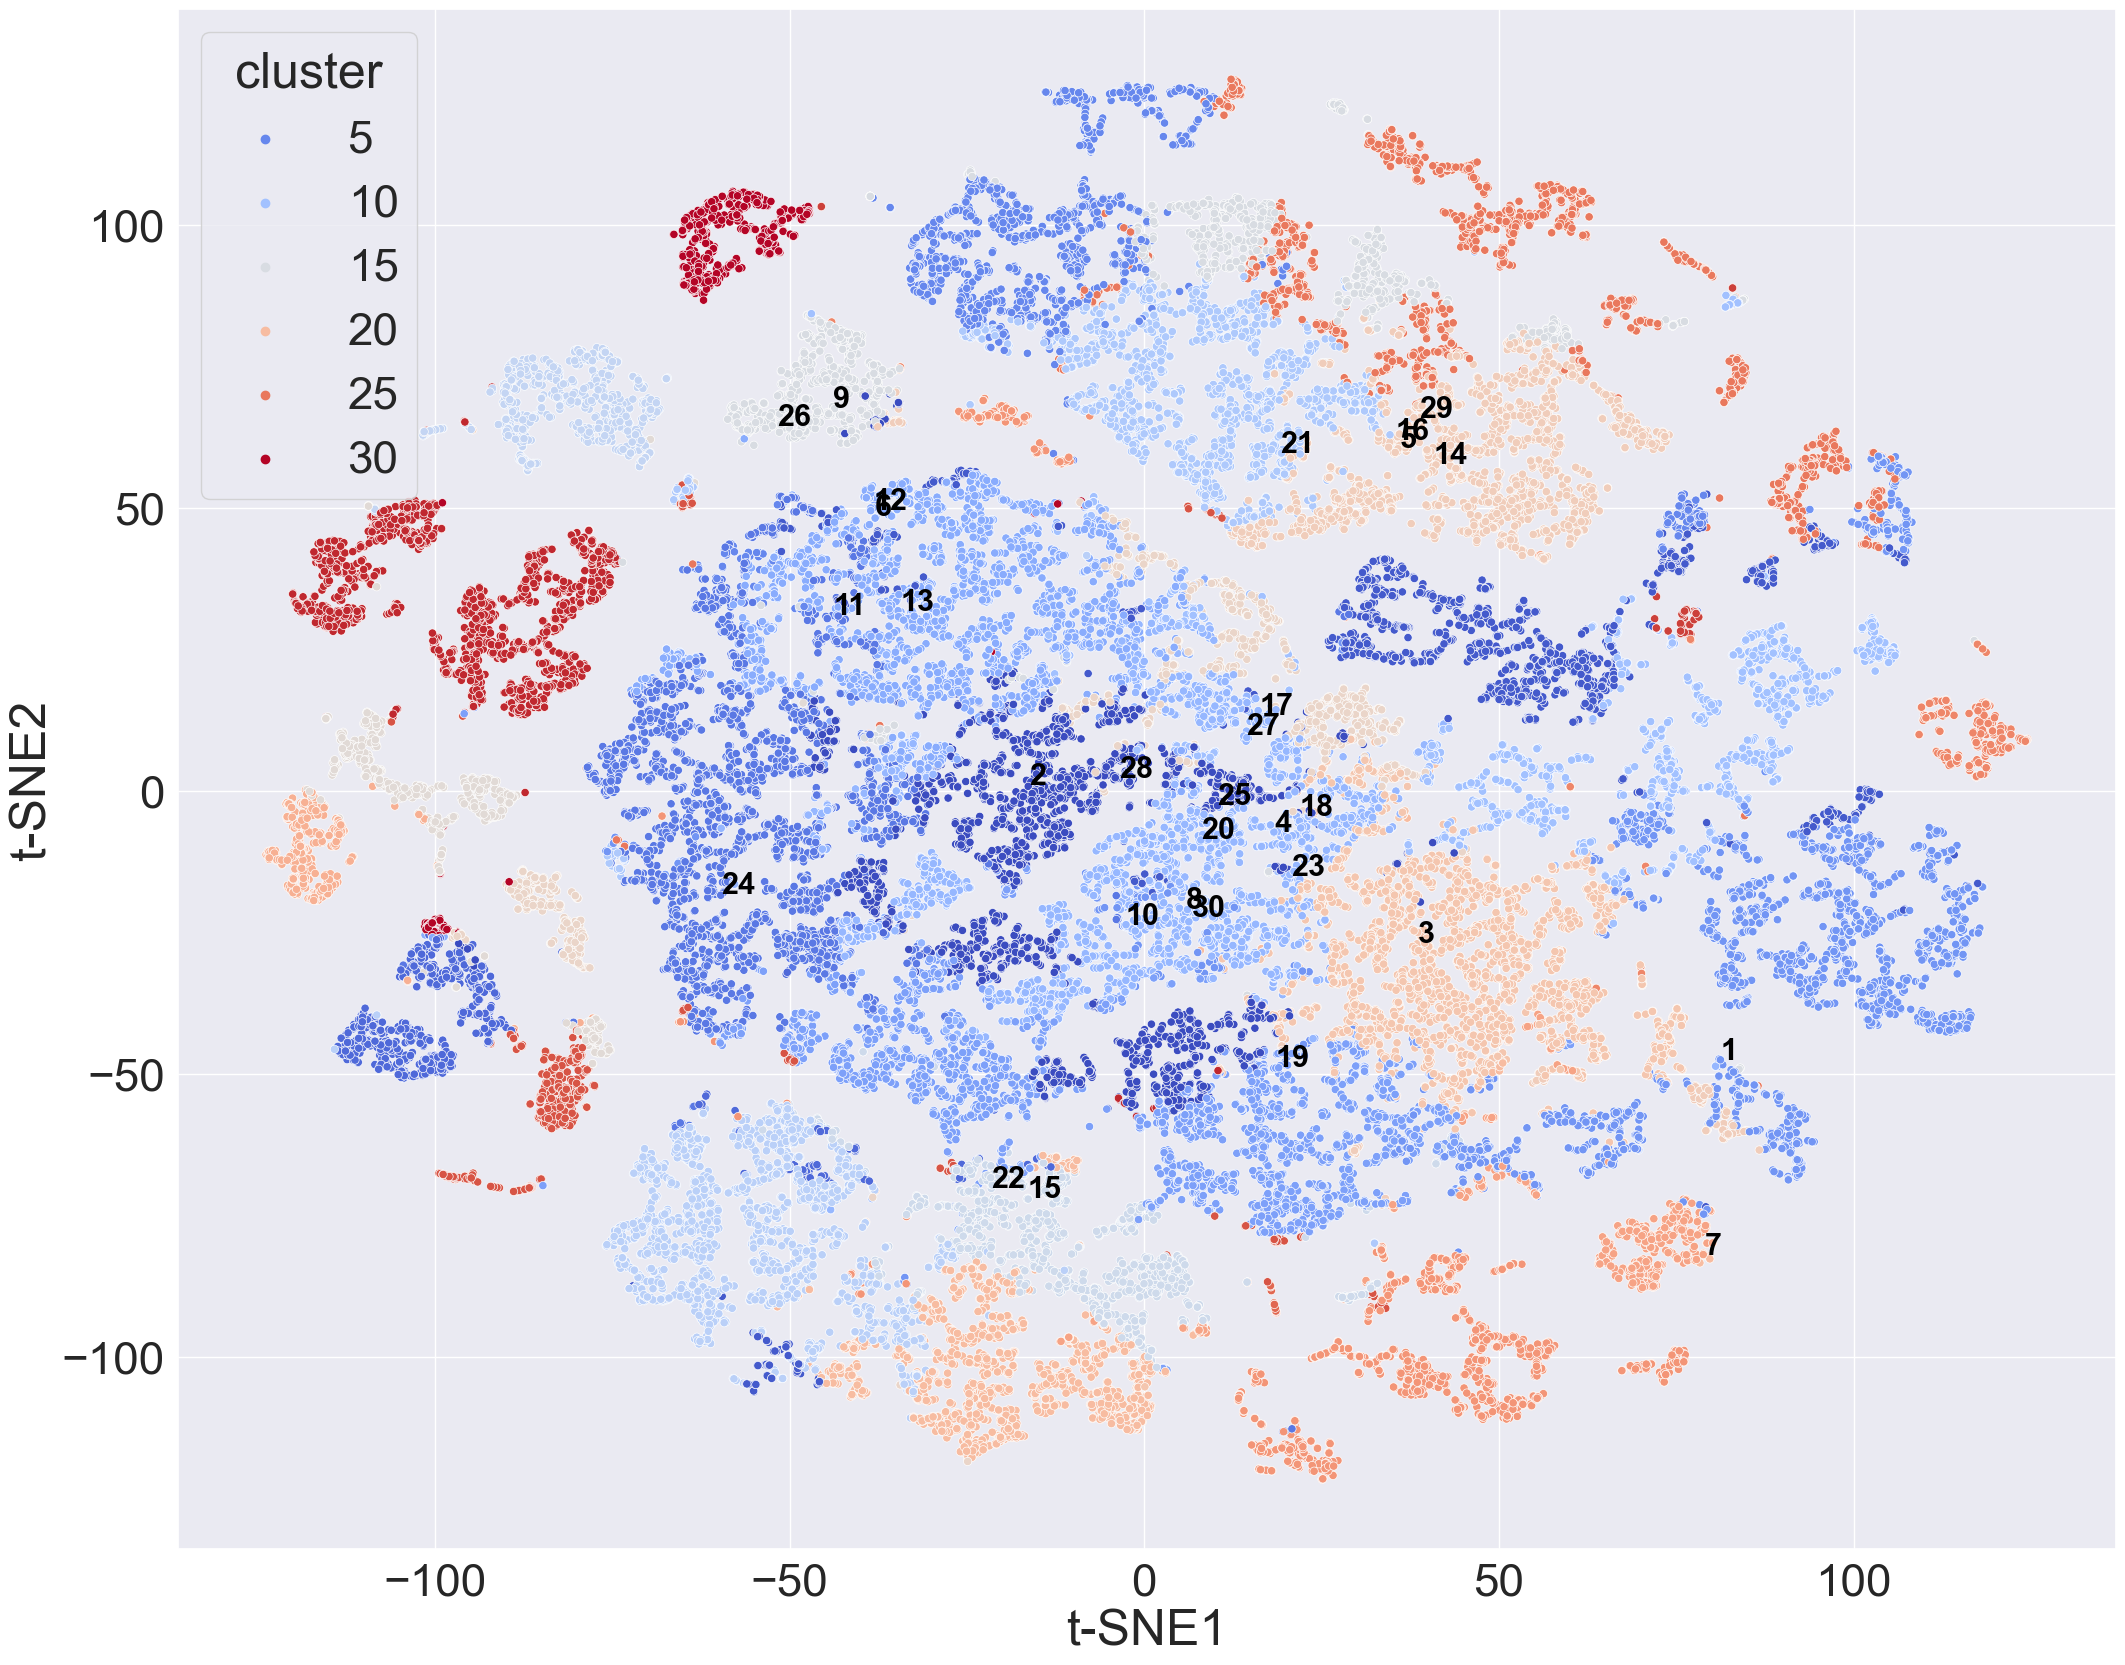

In [12]:
# 2. t-SNE plot
loaded_array = VAE_pred
labels = labels_VAE_Kmeans

tsne_comp = TSNE(n_components=2, perplexity=30, random_state=30, n_iter=1000).fit_transform(loaded_array)

tsne_df = pd.DataFrame(data=tsne_comp, columns=['t-SNE1', 't-SNE2'])
tsne_df.head()

tsne_df = pd.concat([tsne_df, pd.DataFrame({'cluster': labels})], axis=1)
tsne_df['cluster'] += 1
tsne_df.head()

text = []
for i in range(1, 31):
    text.append(str(i))
len(text)

plt.figure(figsize=(25, 20))
sns.set(font_scale=3)
z = sns.color_palette("coolwarm", as_cmap=True)
ax = sns.scatterplot(x="t-SNE1", y="t-SNE2", hue="cluster", data=tsne_df, palette=z)
# ax = sns.color_palette("mako", as_cmap=True)
x = tsne_df['t-SNE1']
y = tsne_df['t-SNE2']
for i in range(0, 30):
    plt.annotate(text[i], (x[i], y[i] + .2), size=22, color='black', weight='bold')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol = 3 )

plt.show()

### Resume of the results obtained for each methods used

Be careful the score for the method using the VAE are computed in the latent space and not in the 'entire' departures space. So, we can not compare them.

###### Kmeans in the entire Space

The metrics have been computed in the input space

| dimension of the space of features used in the model | Method of clustering | Number of clusters | eps | thresold | branching factor | CH       | SC    | DB    |
|------------------------------------------------------|----------------------|--------------------|-----|----------|------------------|----------|-------|-------|
| 251: 'basic' space                                   | Kmeans               | 130                | -   | -        | -                | 533.264  | 0.076 | 1.949 |
| 251: 'basic' space                                   | Kmeans               | 30                 | -   | -        | -                | 1011.817 | 0.058 | 2.329 |

###### Kmeans in the latent Space

The metrics have been computed in the latent space


| dimension of the space of features used in the model | Method of clustering | Number of clusters | CH           | SC        | DB        |
|------------------------------------------------------|----------------------|--------------------|--------------|-----------|-----------|
| 'latent' space (VAE_32)                              | Kmeans               | 25                 | **6747.221** | 0.239     | 1.100     |
| 'latent' space (VAE_32)                              | Kmeans               | 26                 | 6688.481     | 0.236     | 1.103     |
| 'latent' space (VAE_32)                              | Kmeans               | 27                 | 6616.331     | 0.236     | 1.125     |
| 'latent' space (VAE_32)                              | Kmeans               | 28                 | 6579.824     | 0.239     | 1.105     |
| 'latent' space (VAE_32)                              | Kmeans               | 29                 | 6503.428     | 0.239     | **1.085** |
| 'latent' space (VAE_32)                              | Kmeans               | 30                 | 6452.638     | **0.240** | 1.091     |
| 'latent' space (VAE_32)                              | Kmeans               | 31                 | 6353.183     | 0.234     | 1.130     |
| 'latent' space (VAE_32)                              | Kmeans               | 35                 | 6100.477     | 0.231     | 1.139     |
| 'latent' space (VAE_32)                              | Kmeans               | 40                 | 5901.286     | 0.231     | 1.169     |
| 'latent' space (VAE_32)                              | Kmeans               | 50                 | 5454.641     | 0.232     | 1.153     |
| 'latent' space (VAE_32)                              | Kmeans               | 80                 | 4620.676     | 0.234     | 1.147     |

###### BIRCH in the latent Space

The metrics have been computed in the latent space


| dimension of the space of features used in the model | Method of clustering | Number of clusters | eps | thresold | branching factor | CH           | SC        | DB        |
|------------------------------------------------------|----------------------|--------------------|-----|----------|------------------|--------------|-----------|-----------|
| 32: 'latent' space (VAE_32)                          | Birch                | 10                 | -   | 0.5      | 50               | 3966.486     | 0.133     | 1.386     |
| 32: 'latent' space (VAE_32)                          | Birch                | 15                 | -   | 0.5      | 50               | **4262.498** | 0.129     | 1.334     |
| 32: 'latent' space (VAE_32)                          | Birch                | 20                 | -   | 0.5      | 50               | 3832.337     | 0.145     | **1.248** |
| 32: 'latent' space (VAE_32)                          | Birch                | 25                 | -   | 0.5      | 50               | 3809.872     | **0.165** | 1.140     |
| 32: 'latent' space (VAE_32)                          | Birch                | 30                 | -   | 0.5      | 50               | 3451.681     | 0.151     | 1.140     |
| 32: 'latent' space (VAE_32)                          | Birch                | 35                 | -   | 0.5      | 50               | 3589.347     | 0.149     | 1.159     |
| 32: 'latent' space (VAE_32)                          | Birch                | 40                 | -   | 0.5      | 50               | 3260.281     | 0.147     | 1.146     |
| 32: 'latent' space (VAE_32)                          | Birch                | 45                 | -   | 0.5      | 50               | 3232.431     | 0.154     | 1.168     |
| 32: 'latent' space (VAE_32)                          | Birch                | 50                 | -   | 0.5      | 50               | 3080.691     | 0.149     | 1.177     |


###### DBSCAN in the latent Space

The metrics have been computed in the latent space



| dimension of the space of features used in the model | Method of clustering | Number of clusters  | eps | CH      | SC     | DB    |
|------------------------------------------------------|----------------------|---------------------|-----|---------|--------|-------|
| 32: 'latent' space (VAE)                             | DBSCAN               | 94 + outlier points | 0.3 | 170.611 | -0.344 | 1.602 |
| 32: 'latent' space (VAE)                             | DBSCAN               | 19 + outlier points | 0.5 | 100.915 | -0.115 | 1.802 |
| 32: 'latent' space (VAE)                             | DBSCAN               | 15 + outlier points | 0.6 | 112.517 | 0.094  | 1.631 |
| 32: 'latent' space (VAE)                             | DBSCAN               | 12 + outlier points | 0.7 | 137.627 | 0.232  | 1.556 |
| 32: 'latent' space (VAE)                             | DBSCAN               | 6 + outlier points  | 0.8 | 198.313 | 0.348  | 1.603 |
| 32: 'latent' space (VAE)                             | DBSCAN               | 9 + outlier points  | 1.2 | 148.970 | 0.443  | 1.608 |
| 32: 'latent' space (VAE)                             | DBSCAN               | 4 + outlier points  | 1.5 | 128.754 | 0.486  | 1.241 |
| 32: 'latent' space (VAE)                             | DBSCAN               | 2 + outlier points  | 2   | 132.724 | 0.575  | 0.968 |

###### OPTICS in the latent Space

The metrics have been computed in the latent space




| dimension of the space of features used in the model | Method of clustering | Number of clusters    | min_samples | max_eps                | CH      | SC     | DB    |
|------------------------------------------------------|----------------------|-----------------------|-------------|------------------------|---------|--------|-------|
| 32: 'latent' space (VAE)                             | OPTICS               | 1493 + outlier points | 5           | np.inf (default value) | 11.185  | -0.532 | 1.236 |
| 32: 'latent' space (VAE)                             | OPTICS               | 280 + outlier points  | 10          | np.inf (default value) | 25.169  | -0.636 | 1.116 |
| 32: 'latent' space (VAE)                             | OPTICS               | 107 + outlier points  | 15          | np.inf (default value) | 47.644  | -0.598 | 1.012 |
| 32: 'latent' space (VAE)                             | OPTICS               | 23 + outlier points   | 25          | np.inf (default value) | 113.761 | -0.355 | 0.928 |
| 32: 'latent' space (VAE)                             | OPTICS               | 5 + outlier points    | 50          | np.inf (default value) | 121.111 | -0.150 | 0.936 |

###### Bisecting Kmeans in the latent Space

The metrics have been computed in the latent space




| dimension of the space of features used in the model | Method of clustering | Number of clusters | CH       | SC        | DB    |
|------------------------------------------------------|----------------------|--------------------|----------|-----------|-------|
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 5                  | 8112.950 | 0.161     | 1.621 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 10                 | 6677.805 | 0.140     | 1.561 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 15                 | 6371.956 | **0.163** | 1.469 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 20                 | 5715.197 | 0.156     | 1.424 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 25                 | 5190.460 | 0.144     | 1.437 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 30                 | 4971.206 | 0.153     | 1.390 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 35                 | 4753.198 | 0.152     | 1.455 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 40                 | 4671.040 | 0.157     | 1.410 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 45                 | 4443.872 | 0.154     | 1.419 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 50                 | 4242.036 | 0.153     | 1.431 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 60                 | 3952.478 | 0.150     | 1.408 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 70                 | 3695.272 | 0.146     | 1.410 |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 80                 | 3516.554 | 0.144     | 1.399 |


###### Bisecting Kmeans in the latent Space

The metrics have been computed in the latent space



| dimension of the space of features used in the model | Method of clustering | Number of clusters | bandwith | CH      | SC    | DB    |
|------------------------------------------------------|----------------------|--------------------|----------|---------|-------|-------|
| 32: 'latent' space (VAE)                             | Meanshift            | 22                 | None     | 151.947 | 0.233 | 0.847 |
| 32: 'latent' space (VAE)                             | Meanshift            | 8                  | 3        | 213.409 | 0.484 | 1.329 |

### Comparaison to the original article

The metrics have been computed in the input space

| dimension of the space of features used in the model | Clustering method | Number of clusters | CH       | SC    | DB    |
|------------------------------------------------------|-------------------|--------------------|----------|-------|-------|
| 251: 'input' space                                   | Kmeans            | 30                 | 1011.817 | 0.058 | 2.329 |
| 251: 'input' space                                   | BIRCH             | 30                 | 840.342  | 0.042 | 2.181 |
| 251: 'input' space                                   | VAE(16) + Kmeans  | 50                 | 4070.465 | 0.204 | 1.253 |
| 251: 'input' space                                   | VAE(32) + Kmeans  | 50                 | 5472.521 | 0.230 | 1.172 | 
| 251: 'input' space                                   | VAE(64) + Kmeans  | 70                 | 2116.804 | 0.156 | 1.425 |

| dimension of the space of features used in the model | Method of clustering | Number of clusters  | CH           | SC        | DB        |
|------------------------------------------------------|----------------------|---------------------|--------------|-----------|-----------|
| 32: 'latent' space (VAE)                             | DBSCAN               | 19 + outlier points | 100.915      | -0.115    | 1.802     |
| 32: 'latent' space (VAE)                             | DBSCAN               | 12 + outlier points | 137.627      | 0.232     | 1.556     |
| 32: 'latent' space (VAE)                             | Meanshift            | 22                  | 151.947      | 0.233     | **0.847** |
| 32: 'latent' space (VAE)                             | Meanshift            | 8                   | 213.409      | **0.484** | 1.329     |
| 32: 'latent' space (VAE)                             | HDBSCAN              | 11 + outlier points | 652.650      | -0.123    | 2.234     |
| 32: 'latent' space (VAE)                             | Birch                | 15                  | 4262.498     | 0.129     | 1.334     |
| 32: 'latent' space (VAE)                             | Kmeans               | 15                  | **7575.908** | 0.223     | 1.199     |
| 32: 'latent' space (VAE)                             | Bisecting Kmeans     | 15                  | 6371.956     | 0.163     | 1.469     |